The general technique of breaking a large bandwidth signal into many smaller streams is often referred to as channelization, which is an absolutely vital operation in RF processing and communications. There are many different approaches to performing this operation, with the polyphase filterbank being perhaps the most popular. This notebook should show all the steps necessary to contruct a polyphase filterbank from the basic ideas of filtering, the Discrete Fourier transform (DFT, using the np.fft module) and decimation. 
<!-- TEASER_END -->

Polyphase signal processing is an important technique for efficiently resampling and filtering signals. It can be used to resample and filter a single stream, or as part of a polyphase filterbank, which features evenly spaced "channels" of data spaced over a wide bandwitch. It is also an efficient way to get filtered data at rational respamplings i.e. $\frac{4}{3}$, $\frac{7}{5}$, etc.

NOTE
----
If you are already familiar with the concepts of filtering, decimation, and aliasing, feel free to skip to the *Polyphase Filtering* sections below. If not - read on!

Data
-----

Before going over the algorithms, let's generate a sample signal to operate on. The sample used will be a complex chirp that traverses the "normal" recorded audio range ($0:44.1$ kHz) in 1 second. If you aren't familiar with complex data, don't worry about it too much. Just know that it makes the explanation, visualization, and plotting aspects of this notebook simpler. If you are working with "real only" data, these same techniques can still be applied.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

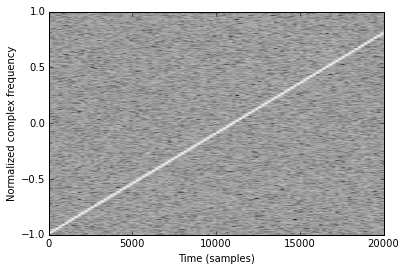

In [2]:
def gen_complex_chirp(fs=44100, pad_frac=.01, time_s=1):
    f0= -fs / (2. * (1 + pad_frac))
    f1= fs / (2. *(1 + pad_frac))
    t1 = time_s
    beta = (f1 - f0) / float(t1)
    t = np.arange(0, t1, t1/ float(fs))
    return np.exp(2j * np.pi * (.5 * beta * (t ** 2) + f0 * t))

def gen_noisy_chirp():
    #Add noise to make it a little less synthetic looking
    chirp = gen_complex_chirp() 
    return chirp + .5 * (np.random.randn(*chirp.shape) + 1j * np.random.randn(*chirp.shape))

def plot_specgram(d, xlim=20000):
    _ = plt.specgram(d, 512, sides="twosided", cmap="gray")
    ax = plt.gca()
    #Remove whitespace on plot
    ax.set_xlim(0, xlim)
    _ = ax.set_ylabel("Normalized complex frequency")
    _ = ax.set_xlabel("Time (samples)")

chirp = gen_noisy_chirp()
plot_specgram(chirp)

Filtering
---------

Filtering is arguably the most critical part of digital signal processing (notated DSP from here on out). For those who are unfamiliar, filtering is accomplished by taking a signal (such as the chirp above) and convolving it  with some other signal, response vector, or data. If you don't remember convolution - think back, sideways, or forward, to calculus! Integrals are basically the continuous equivalent of convolution. Convolution is also very similar to cross-correlation, except one of the two signals is reversed when performing convolution. See the [Wikipedia page](http://en.wikipedia.org/wiki/Convolution) for more detail, but for our purposes it can be done by multiplying, summing, and shifting. Even better, numpy has convolution as a built-in operation.

Since convolution needs a second set of data to operate, we need to generate a digital filter. Typically an FIR filter is used, for reasons I will not discuss here. Just know that FIR filters can generally be used anywhere, while other types of filters such as IIR, need special care to implement and use. Luckily scipy has a lot of good tools for generating all types of filters, and especially FIR filters. We will generate a simple low pass filter here.

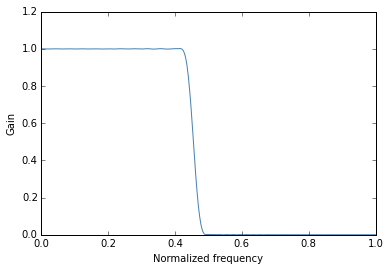

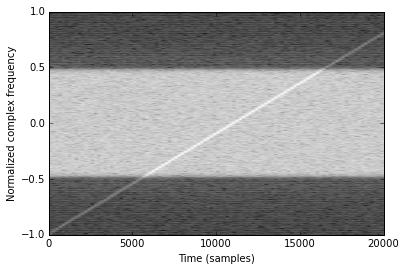

In [3]:
from scipy.signal import firwin, freqz, hilbert

def plot_filter(f, cx=False):
    w, h = freqz(f)
    plt.plot(w / max(w), np.abs(h), color="steelblue")
    if cx:
        plt.plot(-w / max(w), np.abs(h), color="darkred")
    ax = plt.gca()
    ax.set_xlabel("Normalized frequency")
    ax.set_ylabel("Gain")

#Make a filter with an arbitrary number of taps (50) multiplied by decimation factor (2)
#Cutoff is set to avoid aliasing, this will be further discussed
filt = firwin(2 * 50, 1 / (2 * 1.1))
plot_filter(filt)
plt.figure()
filtered_chirp = np.convolve(chirp, filt)
plot_specgram(filtered_chirp)

We can see that the chirp has been filtered. Now you may be saying *"I thought this was a low pass filter, but it took the center of the signal?!?* **WAT**" - hold on! The designed filter is a lowpass filter, but in the complex domain it actually takes the middle of the signal, since the the real part is only shown in the upper half of this graph. The full low-pass filter we designed is actually a bandpass filter in the complex domain - this is crucial for the operation of the polyphase filterbank, and will be utilized extensively.

The plot below more clearly shows the complex response of a low-pass filter, and the filtered output. If all of this is a little confusing, it is probably because I am condensing many classes of DSP into a single IPython notebook. Complex data takes a little while to wrap your head around - just know that getting the middle of the signal for this data is in fact low pass filtering, and will be very useful later.

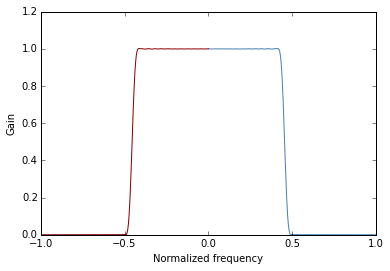

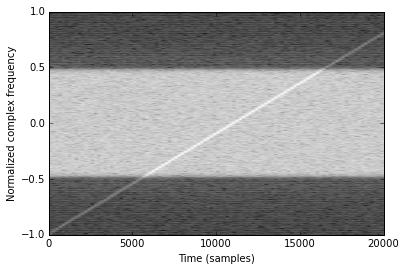

In [4]:
plot_filter(filt, cx=True)
plt.figure()
plot_specgram(filtered_chirp)

Decimation
----------

Now that we have all this nicely filtered data, our next thought is "How can we make this better?". Well, one optimization would be to get rid of data that is no longer useful, namely the part that we just filtered out ($-.5:1$, $.5:1$). This is achieved through an operation called *decimation*. Basically, a decimation by $M$ means to take every $Mth$ datapoint from a signal stream, notated as $\downarrow M$. An simplistic example is shown below.

In [5]:
a = np.arange(12)
print("Full data:")
print(a)
print()
print("Decimated by 2:")
print(a[::2])
print("Alternate decimation by 2:")
print(a[1::2])
print()
print("Decimate by 3, along with alternate decimations:")
print(a[::3])
print(a[1::3])
print(a[2::3])

Full data:
[ 0  1  2  3  4  5  6  7  8  9 10 11]

Decimated by 2:
[ 0  2  4  6  8 10]
Alternate decimation by 2:
[ 1  3  5  7  9 11]

Decimate by 3, along with alternate decimations:
[0 3 6 9]
[ 1  4  7 10]
[ 2  5  8 11]


Now, what happens when we take a decimation by 2 of the chirp data? Sampling theory tells us that no frequency greater than $\frac{f_s}{2}$ can be represented by a signal sampled at frequency rate $f_s$. This means that decimating by 2 will affect any frequency greater than $\frac{f_s}{2\times2} = \frac{f_s}{4}$. Since our original signal went from $-1.0:1.0$ in normalized frequency ($-\pi:\pi$, or $-\frac{f_s}{2}:\frac{f_s}{2}$ in other notation), this means that applying decimation of $M = 2$ would affect any frequency outside $-0.5:0.5$. Our filtered chirp should be OK after decimating by 2 - let's check it out. 

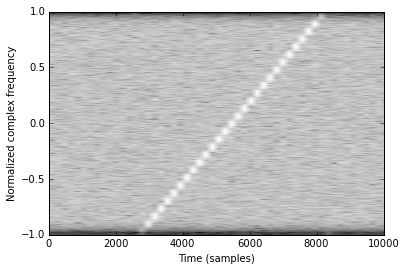

In [6]:
plot_specgram(filtered_chirp[::2], xlim=10000)

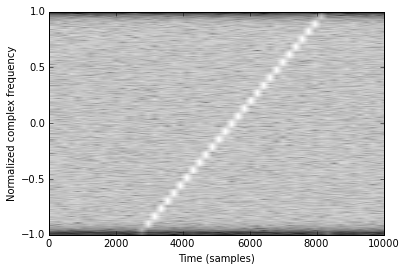

In [7]:
plot_specgram(filtered_chirp[1::2], xlim=10000)

We see that both decimations return a similar stream, and the useless data outside our filter has been eliminated (or so it seems). However, we also notice that the plot limit X axis had to be changed, because we have half of the samples as before in each stream, effectively halving the sampling rate. What happens if we decimate by more than 2?

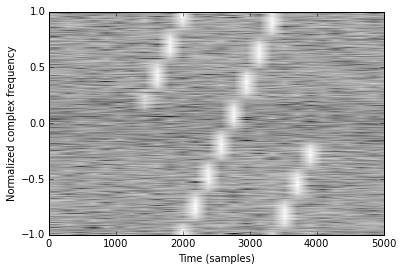

In [8]:
plot_specgram(filtered_chirp[::4], xlim=5000)

**What has happened to our beautiful chirp?** It has been mangled and garbled by excessive decimation. This mangling is known as *aliasing*, and will be the topic of the next section. Aliasing is once of the most critical issues in DSP, and avoiding aliasing while downsampling, in a computationally efficient way, is the entire reason to use polyphase filtering.

Aliasing
--------

Alising is a simple, yet quite deep topic in DSP. In essence, without enough samples it becomes impossible to differentiate different signals, because the samples look the same! A graphical representation can be found [here](http://zone.ni.com/images/reference/en-XX/help/370051V-01/aliasing_effects.gif), as well as in the image below. In practice, this means that high frequency signals (above $\frac{f_s}{2}$ where $f_s$ is the sampling rate) will **look like lower frequencies**. In fact, the higher above the sampling rate a signal is, the lower it will look in frequency! At least until you reach $f_s$... in general, the key is to avoid aliasing at all costs, as it destroys (or at least obscures) information!

In [9]:
from IPython.display import Image
Image(url='http://zone.ni.com/images/reference/en-XX/help/370051V-01/aliasing_effects.gif')

Thinking about this further, you may realize that all signals have aliasing of some form or another. The key difference between the two plots is that one of them had an aliasing signal that was much, much weaker than the in band signal (the signal in $-0.5:0.5$). The second plot still had a large amount of power ouside the "decimation band" since we didn't apply another filter (for $\downarrow M=3$, $-.33:.33$). This is why the corruption was so much more noticeable in the second example! The filter applied to avoid aliasing is sometimes called an "anti-aliasing" filter. Yes, this is related to the AA settings in the video menu of **{insert your favorite video game here}**, though I will save that for a later post. 

Aliasing is tricky, but the general idea is to knock down the power in the "aliasing" part of the signal by as much as possible. Let's recall the processing steps taken to create the last 2 plots.

1. **Filter a signal**
2. **Decimate by a certain value**

Thinking about this, a lot of computation is potentially wasted by filtering samples which are then thrown out in the decimation stage. But if we reverse the order of operations, the signal will be badly aliased! Luckily, some very smart mathematicians and engineers figured out a way to have your cake and eat it, too. **Polyphase filtering**!

Polyphase Filtering, By The Numbers
-----------------------------------

Suppose we design a filter ${\bf h}$ with 6 taps, in a similar way as the filter designed above.

${\bf h} = \left[\begin{array}{h} h_0 & ... & h_5 \end{array}\right]$

This filter is then used on a signal ${\bf x}$ of length 10

${\bf x} = \left[\begin{array}{x} x_0 & ... & x_9 \end{array} \right]$.

After filtering, the output is then decimated by $\downarrow M=3$.

Since convolution ($*$) gives output of length $l_1 + l_2 - 1 = 15$, followed by decimation ($\downarrow M = 3$), the final output will be of length $5$.

$\left[ \begin{array}{h1}h_0 & ... & h_5\end{array}\right] * \left[\begin{array}{x1} x_0 & ... & x_9\end{array}\right] = \left[\begin{array}{s1} s_0 & .. & s_{14} \end{array}\right]$

$\left[\begin{array}{s1} s_0 & .. & s_{14} \end{array}\right] \downarrow M =
\left[\begin{array}{s1} s_0 & s_3 & s_6 & s_{9} & s_{12} \end{array}\right] = 
\left[\begin{array}{s1} y_0 & y_1 & y_2 & y_3 & y_4 \end{array}\right]$

This is exactly what we have shown in the earlier plots and excercises.

A polyphase implementation of this filter/downsample procedure would apply $M$ filters, structured in the following manner (notice 0's are added to ${\bf x}$ in order to get even splits):

$\left[ \begin{array}{h1}h_0 & h_3\end{array}\right] * \left[\begin{array}{x1} x_0 & x_3 & x_6 & x_9 \end{array}\right] = \left[\begin{array}{s1} s_0 & s_3 & s_6 & s_9 & s_{12} \end{array}\right]$

$\left[\begin{array}{h2}h_1 & h_4\end{array}\right] * \left[\begin{array}{x2} x_2 & x_5 & x_8 & 0 \end{array}\right] = \left[\begin{array}{s2} s_2 & s_5 & s_8 & s_{11} & s_{14}=0 \end{array}\right]$

$\left[ \begin{array}{h3}h_2 & h_5\end{array}\right] * \left[\begin{array}{x3} x_1 & x_4 & x_7 & 0 \end{array}\right] = \left[\begin{array}{s3} s_1 & s_4 & s_7 & s_{10} & s_{13}=0 \end{array}\right]$

After this, the final step is to append 0 to the end of the first row and prepend zero to all other rows. That leaves this as the final filtered outputs:

$\left[\begin{array}{ss1} s_0 & s_3 & s_6 & s_9 & s_{12} & 0 \end{array}\right]$

$\left[\begin{array}{ss2} 0 & s_2 & s_5 & s_8 & s_{11} & s_{14}=0 \end{array}\right]$

$\left[\begin{array}{ss3} 0 & s_1 & s_4 & s_7 & s_{10} & s_{13}=0 \end{array}\right]$

Once these filters are applied and the results are adjusted, the 3 resultant vectors ${\bf s}$ are summed. The "all 0 columns" can also dropped, giving a result ${\bf y}$ of:

$\left[\begin{array}{out} y_0 & y_1 & y_2 & y_3 & y_4\end{array} \right]$

${\bf y}$ should be identical to the filter, then downsample case using the same $M$, ${\bf x}$ and ${\bf h}$.

Note that a zero was appended to the first row, and prepended to each row after the first. Also note the row inversion of the ${\bf x}$ coefficients other than the first row ($x_0$ above $x_2$ above $x_1$). This is no accident - in fact, the answers without this inversion and zero padding will be incorrect.

From a high level, these adjustments make sense. The first sample to hit the filter in the typical case would not have any preceding data being filtered, hence $y_0 = s_0 + 0 + 0$. The reordering of the input data is less clear, but is necessary in order to properly align each convolution stream with what would be occuring in the direct filter, then downsample implementation.

This [PDF](http://www.ws.binghamton.edu/fowler/fowler%20personal%20page/EE521_files/IV-05%20Polyphase%20FIlters%20Revised.pdf) is a great resource for digging further into the theory. Now, we move to a working example.

Polyphase Filtering, In The Flesh
---------------------------------

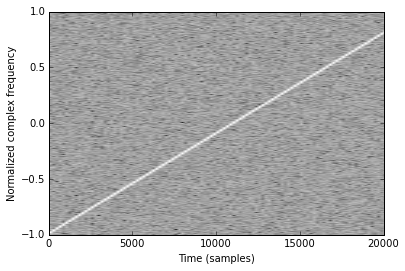

In [10]:
chirp = gen_noisy_chirp()
plot_specgram(chirp)

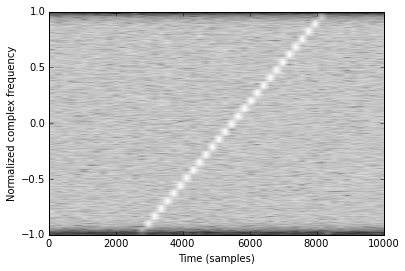

In [11]:
def polyphase_core(x, m, f):
    #x = input data
    #m = decimation rate
    #f = filter
    #Hack job - append zeros to match decimation rate
    if x.shape[0] % m != 0:
        x = np.append(x, np.zeros((m - x.shape[0] % m,)))
    if f.shape[0] % m != 0:
        f = np.append(f, np.zeros((m - f.shape[0] % m,)))
    polyphase = p = np.zeros((m, (x.shape[0] + f.shape[0]) / m), dtype=x.dtype)
    p[0, :-1] = np.convolve(x[::m], f[::m])
    #Invert the x values when applying filters
    for i in range(1, m):
        p[i, 1:] = np.convolve(x[m - i::m], f[i::m])
    return p
        
def polyphase_single_filter(x, m, f):
    return np.sum(polyphase_core(x, m, f), axis=0)
    
filt = firwin(2 * 50, 1 / (2 * 1.1))
filtered_chirp = polyphase_single_filter(chirp, 2, filt)
plot_specgram(filtered_chirp, xlim=10000)

Here we can see that the polyphase filtered output is identical to the earlier filter, then decimate result. We split the polyphase core computation in order to reuse it with the polyphase filterbank, shown later in this notebook. Though the code is a little convoluted, it should provide more computational savings as the decimation rate is increased. See below for an example with $\downarrow M = 10$.

In [12]:
filt = firwin(10 * 50, 1 / (2 * 1.1))

In [13]:
%timeit -n 10 _ = np.convolve(chirp, filt)[::10]

10 loops, best of 3: 18.9 ms per loop


In [14]:
%timeit -n 10 _ = polyphase_single_filter(chirp, 10, filt)

10 loops, best of 3: 3.74 ms per loop


An optimized polyphase filter should beat the optimized convolve-decimate form every time. Even with unoptimized polyphase filter code, we see decent improvement, though this isn't a true benchmark. Depending on the size of the filter, choosing the right convolution code can also be a huge optimization! See [this link](http://wiki.scipy.org/Cookbook/ApplyFIRFilter) for more details. 

Though ndimage.convolve1d may be slightly faster in very specific circumstances, np.convolve seems to be a clearer choice for this tutorial, and is faster for moderate size filters ($50:100$ taps). A typical rule is that filters up to around $64$ taps are faster to apply in the time domain, while >$64$ taps can typically be applied faster using an fftconvolve routine. This is highly platform dependent, but can serve as a decent guideline.

Polypase Filterbank (In Fourier We Trust)
-----------------------------------------

The beauty of the Fourier transform can also be applied to this concept, resulting in multiple, highly efficient resampling filters. We can think of the Fourier transform (FT) in two basic ways. One typical way to think of it is  that the FT converts a single signal into the equivalent frequency representation. The other way is to notice that  $e^{-j \omega t}$ is also equivalent to mixing. This basically means "moving something in frequency", which is key in signal processing and commmunications. This also means a Discrete Fourier Transform (DFT) or Inverse Discrete Fourier Transform (IDFT) can be used to move a particular signal or filter in **discrete frequency steps**. This is the core concept behind Orthogonal Frequency Division Multiplexing (OFDM) in communications, and also the key extension from a *polyphase filter* to a **polyphase filterbank**.

By mixing a filter across the spectrum using the IDFT (using np.fft.ifft), filtering, and downsampling by $\downarrow M$, we are able to get $M$ efficient filter outputs. In multirate signal processing, this approach is known as the *analysis filterbank*, the *transmultiplexer*, *transmux*, or *polyphase filterbank*. Here is an example, with $M = 4$.

In [15]:
def polyphase_analysis(x, m, f):
    return np.fft.ifft(polyphase_core(x, m, f), n=m, axis=0)

filt = firwin(4 * 50, 1 / (4 * 1.1))
an = polyphase_analysis(chirp, 4, filt)

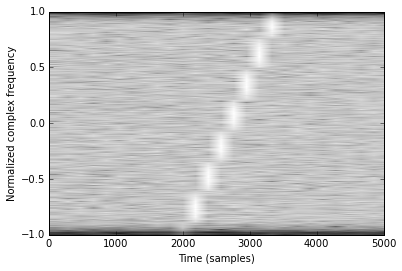

In [16]:
plot_specgram(an[0, :], xlim=5000)

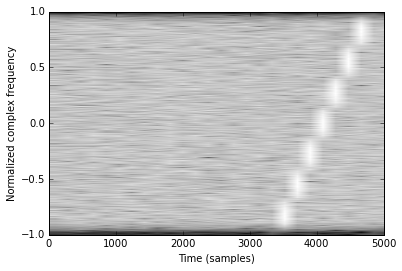

In [17]:
plot_specgram(an[1, :], xlim=5000)

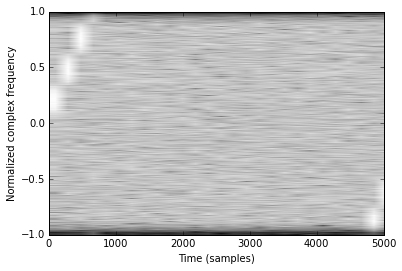

In [18]:
plot_specgram(an[2, :], xlim=5000)

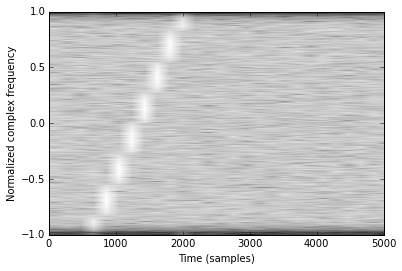

In [19]:
plot_specgram(an[3, :], xlim=5000)

In the plots above, we can see that the lowpass part of the filterbank is in row $0$, the upper parts of the signal are contained in the rows $1:\frac{M}{2}$ (with $\frac{M}{2}$ containing the very highest and very lowest frequencies for even $M$), and the lower parts of the signal in rows $\frac{M}{2}:M$. This ordering is largely due to the use of the IDFT, as opposed to the DFT advocated in some papers. 

The only technical note I have seen on this (DFT/IDFT) subject is found in Multirate Digital Signal Processing by N.J. Fliege, pg 237. It says that in some derivations "the input demultiplexer is realized by a clockwise input commutator [...] In this structure, therefore, a DFT is carried out, and not an IDFT". The logic of the demultiplexer (the inversion of x in polyphase_core) in my code appears to be acting as a counterclockwise commutator, however, the choice between DFT and IDFT simply seems to reorder the output streams.

kk